In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from my_nlp_module.preprocessing import preprocess_bbc_to_dict, PrepOption

from gensim.models import KeyedVectors
from sklearn.utils import shuffle
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import gc
from my_nlp_module.tokenizer import Tokenizer
from my_nlp_module.metrics import Metrics
import matplotlib.pyplot as plt

label_to_class = {
    "business": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "tech": 4
}

class_to_label = {
    0: "business",
    1: "entertainment",
    2: "politics",
    3: "sport",
    4: "tech"
}

path_to_model = "../pretrained_models/40/model.bin"
model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
embed_dim = model.vector_size

2022-12-11 20:51:06.903235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_train_path = "../datasets/bbc-text/train"
dataset_test_path = "../datasets/bbc-text/test"

# Poniżej należy odkomentować testowany zestaw wstępnego przetwarzania

#options = [PrepOption.STOPWORDS, PrepOption.LOWERCASE, PrepOption.LEMMA,
#           PrepOption.NUMBERS, PrepOption.RUBBISH]
options = [PrepOption.NUMBERS, PrepOption.RUBBISH]
preprocessed = preprocess_bbc_to_dict(dataset_train_path, options)

documents = []
labels = []

for key in preprocessed.keys():
    for doc in preprocessed[key]:
        documents.append(doc)
        labels.append(label_to_class[key])
        
preprocessed_test = preprocess_bbc_to_dict(dataset_test_path, options)
    
test_examples = []
test_labels = []

for key in preprocessed_test.keys():
    for doc in preprocessed_test[key]:
        test_examples.append(doc)
        test_labels.append(label_to_class[key])
test_labels = np.array(test_labels)

del preprocessed_test
gc.collect()
        
df = pd.DataFrame({"document": documents, "label": labels})
df = df.sample(frac=1, axis=0).reset_index(drop=True)

df.groupby(['label'])['label'].count()

Couldn't read 1 files:
../datasets/bbc-text/train/sport/199.txt

Couldn't read 0 files:



label
0    459
1    347
2    375
3    458
4    360
Name: label, dtype: int64

In [3]:
MAX_WORDS = 8000
tok = Tokenizer(MAX_WORDS)
tok.fit(list(df['document']))
vocab_size = len(tok.vocab) + 1

embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.vocab.items():
    try:
        embed_vector=model[word]
        embed_matrix[i]=embed_vector
    except KeyError:
        continue

In [4]:
encoded = tok.texts_to_sequences(list(df['document']))
max_doc_len=-1
for doc in encoded:
    if(len(doc)>max_doc_len):
        max_doc_len=len(doc)
print(f"Maximal length of document is {max_doc_len}")

Maximal length of document is 3918


In [5]:
pad_docs = pad_sequences(encoded, maxlen=max_doc_len, padding='post')
print(f"Shape of padded documents array: {pad_docs.shape}")

Shape of padded documents array: (1999, 3918)


In [6]:
Y=df['label']
x_train,x_test,y_train,y_test=train_test_split(pad_docs,Y,test_size=0.20,random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

2022-12-11 20:51:54.297913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
print(x_train.shape, x_test.shape)

(1599, 3918) (400, 3918)


In [8]:
classifier=tf.keras.models.Sequential()
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                      input_length=max_doc_len, weights=[embed_matrix],
                                      trainable=True, name="kodowanie_wyrazow")
classifier.add(embedding)

classifier.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name="dwukierunkowe_LSTM"))
classifier.add(tf.keras.layers.Dense(84, activation='relu', name="warstwa_ukryta"))
classifier.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax, name='klasyfikator'))

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

epochs = 8

steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)

optimizer1 = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule)

selected_optimizer = "adam"
optimizers = {
    "optimizer1": optimizer1,
    "adam": "adam",
    "sgd": "sgd"
}

classifier.compile(optimizer=optimizers[selected_optimizer],
                        loss=loss,
                        metrics=metrics)



classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 kodowanie_wyrazow (Embeddin  (None, 3918, 100)        800100    
 g)                                                              
                                                                 
 dwukierunkowe_LSTM (Bidirec  (None, 128)              84480     
 tional)                                                         
                                                                 
 warstwa_ukryta (Dense)      (None, 84)                10836     
                                                                 
 klasyfikator (Dense)        (None, 5)                 425       
                                                                 
Total params: 895,841
Trainable params: 895,841
Non-trainable params: 0
_________________________________________________________________


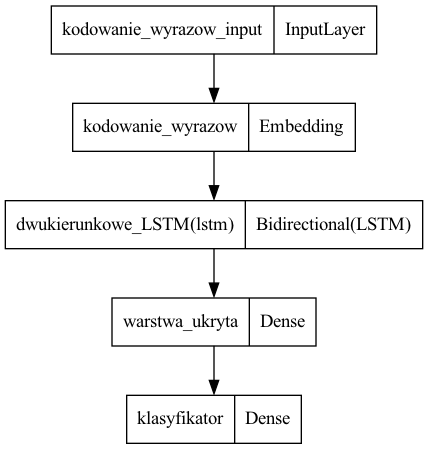

In [9]:
tf.keras.utils.plot_model(classifier)

In [10]:
# free memory
del model
del preprocessed
del df
del pad_docs
gc.collect()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                            min_delta=0.005, patience=5, mode='max')
history = classifier.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test), callbacks=[early_stop])

Epoch 1/8
50/50 [==============================] - 131s 3s/step - loss: 1.2469 - sparse_categorical_accuracy: 0.5116 - val_loss: 0.7270 - val_sparse_categorical_accuracy: 0.7350
Epoch 2/8
50/50 [==============================] - 125s 2s/step - loss: 0.4950 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.3605 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/8
50/50 [==============================] - 124s 2s/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9175
Epoch 4/8
50/50 [==============================] - 124s 2s/step - loss: 0.1257 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.9175
Epoch 5/8
50/50 [==============================] - 124s 2s/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.2732 - val_sparse_categorical_accuracy: 0.9100
Epoch 6/8
50/50 [==============================] - 124s 2s/step - loss: 0.0618 - sparse_categorical_accuracy: 

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


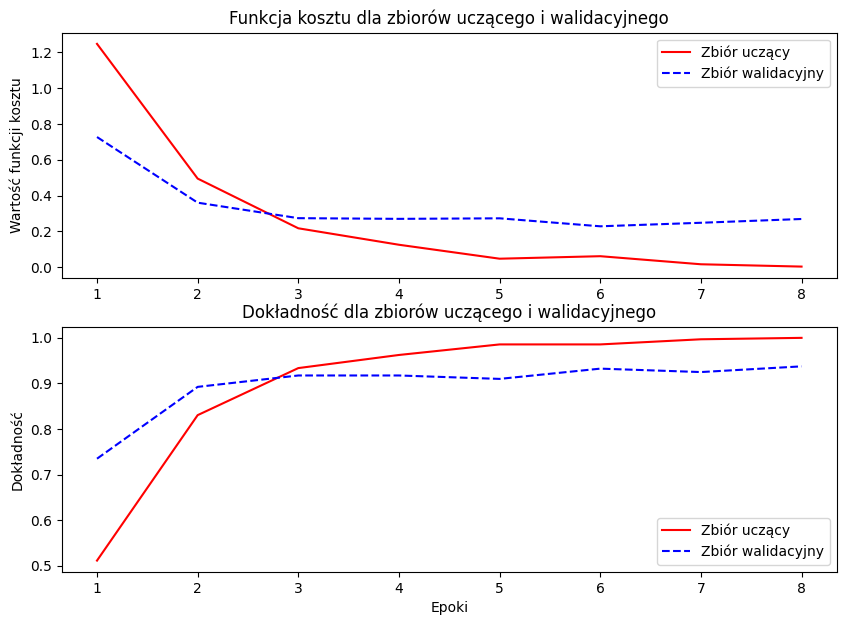

In [11]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 7))
fig.tight_layout(pad=10)

plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_loss, '--b', label='Zbiór walidacyjny')
plt.title('Funkcja kosztu dla zbiorów uczącego i walidacyjnego')
plt.ylabel('Wartość funkcji kosztu')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_acc, '--b', label='Zbiór walidacyjny')
plt.title('Dokładność dla zbiorów uczącego i walidacyjnego')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')

In [12]:
encoded_test = tok.texts_to_sequences(test_examples)
for i, enc in enumerate(encoded_test):
    if len(enc) < max_doc_len:
        encoded_test[i] = pad_sequences([enc], maxlen=max_doc_len, padding='post')[0]
    elif len(enc) > max_doc_len:
        encoded_test[i] = encoded_test[i][:max_doc_len]
encoded_test = np.array(encoded_test)

def predict_function(model, x):
    result = []
    outputs = model.predict(x, verbose=0)
    for out in outputs:
        class_number = int(tf.math.argmax(out))
        result.append(class_number)
    return np.array(result)

metrics = Metrics(classifier, predict_function)
print("Metryki dla zbioru testowego")
_ = metrics.accuracy(encoded_test, test_labels)
_ = metrics.precision(encoded_test, test_labels)
_ = metrics.recall(encoded_test, test_labels)
_ = metrics.f1(encoded_test, test_labels)

Metryki dla zbioru testowego
Dokładność: 0.9555555555555556
Precyzja: [0.95833333 0.95       0.95454545 0.94545455 0.97368421]
Czułość: [0.90196078 0.97435897 1.         1.         0.90243902]
F1: [0.92929293 0.96202532 0.97674419 0.97196262 0.93670886]


In [14]:
metrics.print_confusion_matrix(encoded_test, test_labels)
metrics.print_metrics(encoded_test, test_labels)

[[46  1  2  1  1]
 [ 0 38  0  1  0]
 [ 0  0 42  0  0]
 [ 0  0  0 52  0]
 [ 2  1  0  1 37]]
╒═══════╤═══════╤═══════╤═══════╤═══════╕
│ 0.958 │ 0.95  │ 0.955 │ 0.945 │ 0.974 │
├───────┼───────┼───────┼───────┼───────┤
│ 0.902 │ 0.974 │ 1     │ 1     │ 0.902 │
├───────┼───────┼───────┼───────┼───────┤
│ 0.929 │ 0.962 │ 0.977 │ 0.972 │ 0.937 │
╘═══════╧═══════╧═══════╧═══════╧═══════╛
Dokładność: 0.956


In [15]:
print(f"Parametry modelu:\nwstępne przetwarzanie: {options}\nilość epok: {epochs}\nalgorytm optymalizacyjny: {selected_optimizer}")

Parametry modelu:
wstępne przetwarzanie: [<PrepOption.NUMBERS: 7>, <PrepOption.RUBBISH: 6>]
ilość epok: 8
algorytm optymalizacyjny: adam


In [16]:
df5 = pd.DataFrame({"document": test_examples, "label": test_labels})

df5.groupby(['label'])['label'].count()

label
0    51
1    39
2    42
3    52
4    41
Name: label, dtype: int64